# RNN과 CNN

In [ ]:
#Python≥3.5 is required
import sys
assert sys.version_info>=(3,5)

#Scikit-Learn≥0.20 is required
import sklearn
assert sklearn.__version__>="0.20"

try:
  #%tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  IS_COLAB=True
except Exception:
  IS_COLAB=False

#TensorFlow≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__>="2.0"

if not tf.config.list_physical_devices('GPU'):
  print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
  if IS_COLAB:
    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

#Common imports
import numpy as np
import os
from pathlib import Path

#to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

## 시계열 예측하기

Generate the Dataset

In [ ]:
def generate_time_series(batch_size,n_steps):
  freq1,freq2,offsets1,offsets2=np.random.rand(4,batch_size,1)
  time=np.linspace(0,1,n_steps)
  series=0.5*np.sin((time-offsets1)*(freq1*10+10))  #wave1
  series+=0.2*np.sin((time-offsets2)*(freq2*20+20)) #+wave2
  series+=0.1*(np.random.rand(batch_size,n_steps)-0.5)  #+noise
  return series[...,np.newaxis].astype(np.float32)

In [ ]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000,n_steps+1)
X_train,y_train=series[:7000,:n_steps],series[:7000,-1]
X_valid,y_valid=series[7000:9000,:n_steps],series[7000:9000,-1]
X_test,y_test=series[9000:,:n_steps],series[9000:,-1]

In [ ]:
X_train.shape,y_train.shape

((7000, 50, 1), (7000, 1))

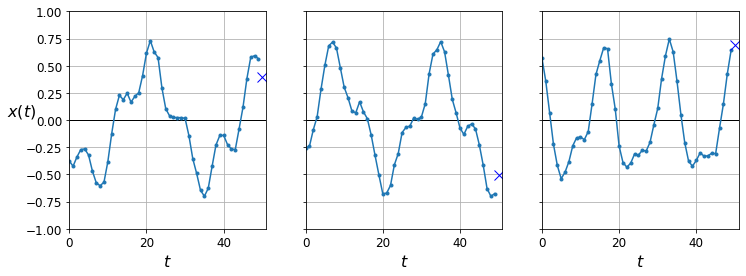

In [ ]:
def plot_series(series,y=None,y_pred=None,x_label="$t$",y_label="$x(t)$"):
  plt.plot(series,".-")
  if y is not None:
    plt.plot(n_steps,y,"bx",markersize=10)
  if y_pred is not None:
    plt.plot(n_steps,y_pred,"ro")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label,fontsize=16)
  if y_label:
    plt.ylabel(y_label,fontsize=16,rotation=0)
  plt.hlines(0,0,100,linewidth=1)
  plt.axis([0,n_steps+1,-1,1])

fig,axes=plt.subplots(nrows=1,ncols=3,sharey=True,figsize=(12,4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col,:,0],y_valid[col,0],
              y_label=("$x(t)$"if col==0 else None))
plt.show()

### 기준 성능

Naive predictions (just predict the last observed value) :

In [ ]:
y_pred=X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid,y_pred))

0.020211367

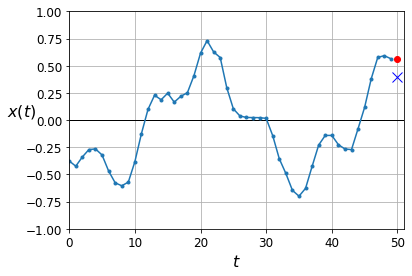

In [ ]:
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

Linear predictions :

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.Flatten(input_shape=[50,1]),
                               keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer="adam")
history=model.fit(X_train,y_train,epochs=20,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 3s 4ms/step - loss: 0.1398 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0142 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0062

In [ ]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168085753917694

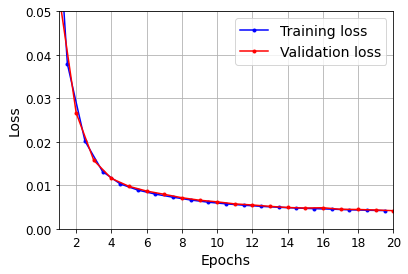

In [ ]:
def plot_learning_curves(loss,val_loss):
  plt.plot(np.arange(len(loss))+0.5,loss,"b.-",label="Training loss")
  plt.plot(np.arange(len(val_loss))+1,val_loss,"r.-",label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.axis([1,20,0,0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

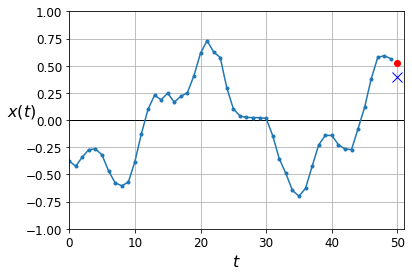

In [ ]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### 간단한 RNN 구현하기

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.SimpleRNN(1,input_shape=[None,1])
])

optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse",optimizer=optimizer)
history=model.fit(X_train,y_train,epochs=20,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 9s 38ms/step - loss: 0.1554 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0409 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0277 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0208 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0138 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0128 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0117 - val_lo

In [ ]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.010881561785936356

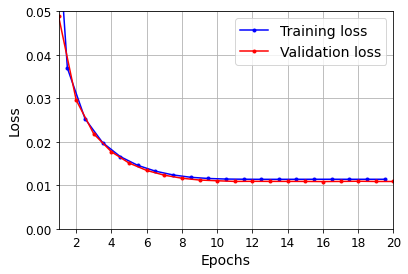

In [ ]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

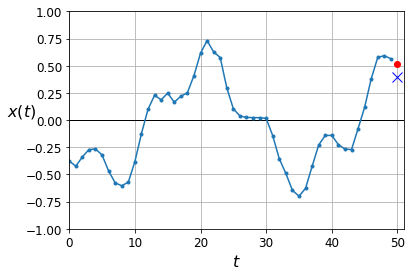

In [ ]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### 심층 RNN

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.SimpleRNN(20,return_sequences=True),
                               keras.layers.SimpleRNN(1)
])

model.compile(loss="mse",optimizer="adam")
history=model.fit(X_train,y_train,epochs=20,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 24s 105ms/step - loss: 0.1324 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 22s 98ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 22s 99ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 22s 101ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 21s 97ms/step - loss

In [ ]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0029


0.002910558832809329

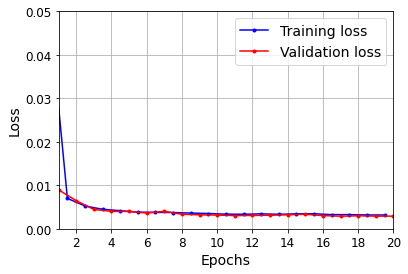

In [ ]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

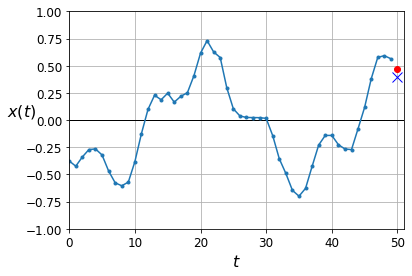

In [ ]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

Make the second SimpleRNN layer return only the last output :

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.SimpleRNN(20),
                               keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer="adam")
history=model.fit(X_train,y_train,epochs=20,
                  validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 17s 73ms/step - loss: 0.0566 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 15s 66ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 15s 68ms/step - loss: 0.002

In [ ]:
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0026


0.002623625099658966

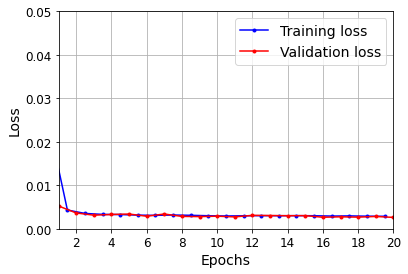

In [ ]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

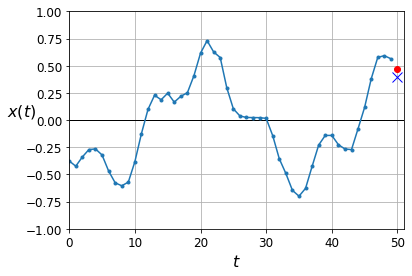

In [ ]:
y_pred=model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### 여러 타임 스텝 앞을 예측하기

In [ ]:
np.random.seed(43) #not 42, as it would give the first series in the train set

series=generate_time_series(1,n_steps+10)
X_new,Y_new=series[:,:n_steps],series[:,n_steps:]
X=X_new
for step_ahead in range(10):
  y_pred_one=model.predict(X[:,step_ahead:])[:,np.newaxis,:]
  X=np.concatenate([X,y_pred_one],axis=1)

Y_pred=X[:,n_steps:]

In [ ]:
Y_pred.shape

(1, 10, 1)

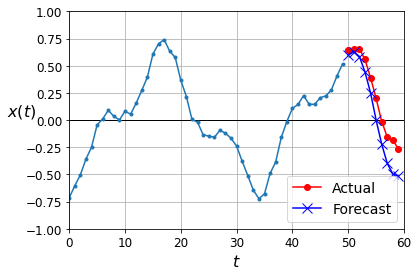

In [ ]:
def plot_multiple_forecasts(X,Y,Y_pred):
  n_steps=X.shape[1]
  ahead=Y.shape[1]
  plot_series(X[0,:,0])
  plt.plot(np.arange(n_steps,n_steps+ahead),Y[0,:,0],"ro-",label="Actual")
  plt.plot(np.arange(n_steps,n_steps+ahead),Y_pred[0,:,0],"bx-",label="Forecast",markersize=10)
  plt.axis([0,n_steps+ahead,-1,1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

Now let's use this model to predict the next 10 values.  
We first need to regenerate the sequences with 9 more time steps.

In [ ]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000,n_steps+10)
X_train,Y_train=series[:7000,:n_steps],series[:7000,-10:,0]
X_valid,Y_valid=series[7000:9000,:n_steps],series[7000:9000,-10:,0]
X_test,Y_test=series[9000:,:n_steps],series[9000:,-10:,0]

Now let's predict the next 10 values one by one :

In [ ]:
X=X_valid
for step_ahead in range(10):
  y_pred_one=model.predict(X)[:,np.newaxis,:]
  X=np.concatenate([X,y_pred_one],axis=1)

Y_pred=X[:,n_steps:,0]

In [ ]:
Y_pred.shape

(2000, 10)

In [ ]:
np.mean(keras.metrics.mean_squared_error(Y_valid,Y_pred))

0.027510807

Let's compare this performance with some baselines :  
naive predictions and a simple linear model :

In [ ]:
Y_naive_pred=Y_valid[:,-1:]
np.mean(keras.metrics.mean_squared_error(Y_valid,Y_naive_pred))

0.22278848

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.Flatten(input_shape=[50,1]),
                               keras.layers.Dense(10)
])

model.compile(loss="mse",optimizer="adam")
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0222

Now let's create an RNN that predicts all 10 next values at once :

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.SimpleRNN(20),
                               keras.layers.Dense(10)
])

model.compile(loss="mse",optimizer="adam")
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 17s 72ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 17s 77ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 16s 72ms/step - loss: 0.011

In [ ]:
np.random.seed(43)

series=generate_time_series(1,50+10)
X_new,Y_new=series[:,:50,:],series[:,-10:,:]
Y_pred=model.predict(X_new)[...,np.newaxis]

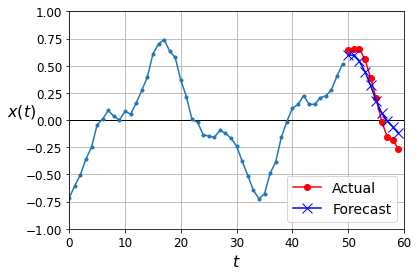

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step.  
That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step.  
Notice that the model is causal : when it makes predictions at any time step, it can only see past time steps.

In [ ]:
np.random.seed(42)

n_steps=50
series=generate_time_series(10000,n_steps+10)
X_train=series[:7000,:n_steps]
X_valid=series[7000:9000,:n_steps]
X_test=series[9000:,:n_steps]
Y=np.empty((10000,n_steps,10))
for step_ahead in range(1,10+1):
  Y[...,step_ahead-1]=series[...,step_ahead:step_ahead+n_steps,0]
Y_train=Y[:7000]
Y_valid=Y[7000:9000]
Y_test=Y[9000:]

In [ ]:
X_train.shape,Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.SimpleRNN(20,return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true,Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:,-1],Y_pred[:,-1])

model.compile(loss="mse",optimizer=keras.optimizers.Adam(lr=0.01),metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 67ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0352 - val_last_time_step_mse: 0.0244
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0335 - last_time_step_mse: 0.0222 - val_loss: 0.0361 - val_last_time_step_mse: 0.0271
Epoch 4/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0309 - last_time_step_mse: 0.0205 - val_loss: 0.0279 - val_last_time_step_mse: 0.0159
Epoch 5/20
219/219 [==============================] - 15s 68ms/step - loss: 0.0279 - last_time_step_mse: 0.0164 - val_loss: 0.0257 - val_last_time_step_mse: 0.0135
Epoch 6/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0259 - last_time_step_mse: 0.0135 - val_loss: 0.0223 - val_last_time_step_mse: 0.0089
Epoch 7/20
219/2

In [ ]:
np.random.seed(43)

series=generate_time_series(1,50+10)
X_new,Y_new=series[:,:50,:],series[:,50:,:]
Y_pred=model.predict(X_new)[:,-1][...,np.newaxis]

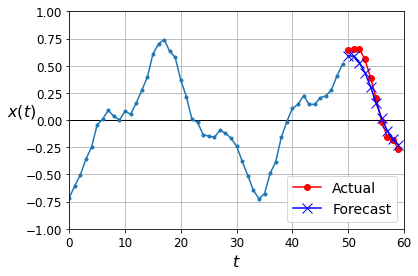

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

## 긴 시퀀스 다루기

### 불안정한 그레이디언트 문제와 싸우기

Deep RNN with Batch Norm

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.BatchNormalization(),
                               keras.layers.SimpleRNN(20,return_sequences=True),
                               keras.layers.BatchNormalization(),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 17s 70ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 15s 67ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/2

Deep RNNs with Layer Norm

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
  def __init__(self,units,activation="tanh",**kwargs):
    super().__init__(**kwargs)
    self.state_size=units
    self.output_size=units
    self.simple_rnn_cell=keras.layers.SimpleRNNCell(units,activation=None)
    self.layer_norm=LayerNormalization()
    self.activation=keras.activations.get(activation)
  def get_initial_state(self,inputs=None,batch_size=None,dtype=None):
    if inputs is not None:
      batch_size=tf.shape(inputs)[0]
      dtype=inputs.dtype
    return [tf.zeros([batch_size,self.state_size],dtype=dtype)]
  def call(self,inputs,states):
    outputs,new_states=self.simple_rnn_cell(inputs,states)
    norm_outputs=self.activation(self.layer_norm(outputs))
    return norm_outputs,[norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.RNN(LNSimpleRNNCell(20),return_sequences=True,
                                                input_shape=[None,1]),
                               keras.layers.RNN(LNSimpleRNNCell(20),return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 42s 162ms/step - loss: 0.2935 - last_time_step_mse: 0.2943 - val_loss: 0.0745 - val_last_time_step_mse: 0.0699
Epoch 2/20
219/219 [==============================] - 35s 160ms/step - loss: 0.0684 - last_time_step_mse: 0.0610 - val_loss: 0.0567 - val_last_time_step_mse: 0.0500
Epoch 3/20
219/219 [==============================] - 34s 154ms/step - loss: 0.0556 - last_time_step_mse: 0.0483 - val_loss: 0.0487 - val_last_time_step_mse: 0.0399
Epoch 4/20
219/219 [==============================] - 34s 155ms/step - loss: 0.0477 - last_time_step_mse: 0.0380 - val_loss: 0.0442 - val_last_time_step_mse: 0.0350
Epoch 5/20
219/219 [==============================] - 35s 158ms/step - loss: 0.0425 - last_time_step_mse: 0.0322 - val_loss: 0.0392 - val_last_time_step_mse: 0.0285
Epoch 6/20
219/219 [==============================] - 33s 152ms/step - loss: 0.0391 - last_time_step_mse: 0.0278 - val_loss: 0.0370 - val_last_time_step_mse: 0.0253
Epoch 7/20

Creating a Custom RNN Class

In [ ]:
class MyRNN(keras.layers.Layer):
  def __init__(self,cell,return_sequences=False,**kwargs):
    super().__init__(**kwargs)
    self.cell=cell
    self.return_sequences=return_sequences
    self.get_initial_state=getattr(
        self.cell,"get_initial_state",self.fallback_initial_state
    )
  def fallback_initial_state(self,inputs):
    return [tf.zeros([self.cell.state_size],dtype=inputs.dtype)]
  @tf.function
  def call(self,inputs):
    states=self.get_initial_state(inputs)
    n_steps=tf.shape(inputs)[1]
    if self.return_sequences:
      sequences=tf.TensorArray(inputs.dtype,size=n_steps)
    outputs=tf.zeros(shape=[n_steps,self.cell.output_size],dtype=inputs.dtype)
    for step in tf.range(n_steps):
      outputs,states=self.cell(inputs[:,step],states)
      if self.return_sequences:
        sequences=sequences.write(step,outputs)
    if self.return_sequences:
      return sequences.stack()
    else:
      return outputs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               MyRNN(LNSimpleRNNCell(20),return_sequences=True,
                                     input_shape=[None,1]),
                               MyRNN(LNSimpleRNNCell(20),return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 35s 152ms/step - loss: 0.3618 - last_time_step_mse: 0.3636 - val_loss: 0.0775 - val_last_time_step_mse: 0.0728
Epoch 2/20
219/219 [==============================] - 32s 144ms/step - loss: 0.0729 - last_time_step_mse: 0.0658 - val_loss: 0.0636 - val_last_time_step_mse: 0.0576
Epoch 3/20
219/219 [==============================] - 31s 140ms/step - loss: 0.0626 - last_time_step_mse: 0.0566 - val_loss: 0.0575 - val_last_time_step_mse: 0.0506
Epoch 4/20
219/219 [==============================] - 33s 149ms/step - loss: 0.0561 - last_time_step_mse: 0.0481 - val_loss: 0.0495 - val_last_time_step_mse: 0.0390
Epoch 5/20
219/219 [==============================] - 33s 149ms/step - loss: 0.0480 - last_time_step_mse: 0.0370 - val_loss: 0.0450 - val_last_time_step_mse: 0.0342
Epoch 6/20
219/219 [==============================] - 31s 141ms/step - loss: 0.0439 - last_time_step_mse: 0.0322 - val_loss: 0.0411 - val_last_time_step_mse: 0.0292
Epoch 7/20

### 단기 기억 문제 해결하기

LSTMs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.LSTM(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.LSTM(20,return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 11ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [ ]:
model.evaluate(X_valid,Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788686841726303, 0.008560807444155216]

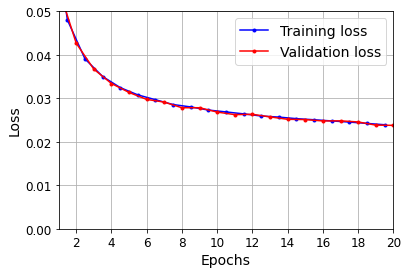

In [ ]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series=generate_time_series(1,50+10)
X_new,Y_new=series[:,:50,:],series[:,50:,:]
Y_pred=model.predict(X_new)[:,-1][...,np.newaxis]

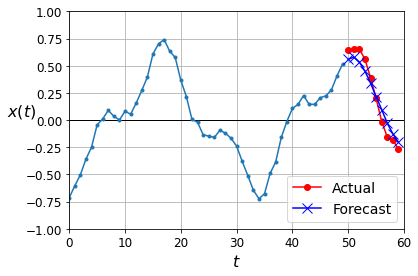

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.GRU(20,return_sequences=True,input_shape=[None,1]),
                               keras.layers.GRU(20,return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 10ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

In [ ]:
model.evaluate(X_valid,Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.02378549799323082, 0.0102628068998456]

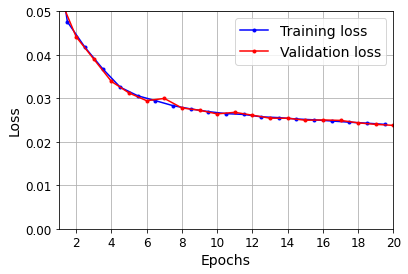

In [ ]:
plot_learning_curves(history.history["loss"],history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series=generate_time_series(1,50+10)
X_new,Y_new=series[:,:50,:],series[:,50:,:]
Y_pred=model.predict(X_new)[:,-1][...,np.newaxis]

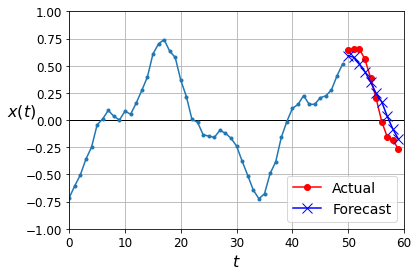

In [ ]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential([
                               keras.layers.Conv1D(filters=20,kernel_size=4,strides=2,padding="valid",
                                                   input_shape=[None,1]),
                               keras.layers.GRU(20,return_sequences=True),
                               keras.layers.GRU(20,return_sequences=True),
                               keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train[:,3::2],epochs=20,
                  validation_data=(X_valid,Y_valid[:,3::2]))

Epoch 1/20
219/219 [==============================] - 4s 9ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model=keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1,2,4,8)*2:
  model.add(keras.layers.Conv1D(filters=20,kernel_size=2,padding="causal",
                                activation="relu",dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10,kernel_size=1))
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=20,
                  validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0981 - last_time_step_mse: 0.0890 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0339 - last_time_step_mse: 0.0211 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0291 - last_time_step_mse: 0.0164 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0265 - last_time_step_mse: 0.0142 - val_loss: 0.0255 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0251 - last_time_step_mse: 0.0129 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0242 - last_time_step_mse: 0.0121 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

Here is the original WaveNet defined in the paper :  
it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences :

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
  def __init__(self,activation="tanh",**kwargs):
    super().__init__(**kwargs)
    self.activation=keras.activations.get(activation)
  def call(self,inputs):
    n_filters=inputs.shape[-1]//2
    linear_output=self.activation(inputs[...,:n_filters])
    gate=keras.activations.sigmoid(inputs[...,n_filters:])
    return self.activation(linear_output)*gate

In [ ]:
def wavenet_residual_block(inputs,n_filters,dilation_rate):
  z=keras.layers.Conv1D(2*n_filters,kernel_size=2,padding="causal",
                        dilation_rate=dilation_rate)(inputs)
  z=GatedActivationUnit()(z)
  z=keras.layers.Conv1D(n_filters,kernel_size=1)(z)
  return keras.layers.Add()([z,inputs]),z

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block=3  #10 in the paper
n_blocks=1  #3 in the paper
n_filters=32  #128 in the paper
n_outputs=10  #256 in the paper

inputs=keras.layers.Input(shape=[None,1])
z=keras.layers.Conv1D(n_filters,kernel_size=2,padding="causal")(inputs)
skip_to_last=[]
for dilation_rate in [2**i for i in range(n_layers_per_block)]*n_blocks:
  z,skip=wavenet_residual_block(z,n_filters,dilation_rate)
  skip_to_last.append(skip)
z=keras.activations.relu(keras.layers.Add()(skip_to_last))
z=keras.layers.Conv1D(n_filters,kernel_size=1,activation="relu")(z)
Y_proba=keras.layers.Conv1D(n_outputs,kernel_size=1,activation="softmax")(z)

model=keras.models.Model(inputs=[inputs],outputs=[Y_proba])

In [ ]:
model.compile(loss="mse",optimizer="adam",metrics=[last_time_step_mse])
history=model.fit(X_train,Y_train,epochs=2,
                  validation_data=(X_valid,Y_valid))

Epoch 1/2
219/219 [==============================] - 3s 8ms/step - loss: 0.1387 - last_time_step_mse: 0.1347 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 1s 6ms/step - loss: 0.1222 - last_time_step_mse: 0.1161 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189
